## Imports

In [1]:
import json
import os
import time
import torch
import torch.utils.data
import torch.optim as optim
from torchvision import transforms
from my_dataset import MyDataSet
from utils import split_data, create_lr_scheduler, get_params_groups, train_one_epoch, evaluate
import numpy as np

/home/lorenzo/miniconda3/envs/rfdet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters set

In [6]:
device = 'cuda:0'
data_path = "../2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
snr_range = [-20, 30]
snr_step = 2
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
num_classes = 24
model = "convnetBN"
if model == 'convnext':
    from model import convnext as create_model
elif model == "convnet":
    from models.convnet import ConvNet as create_model
    L=2
    C=25
elif model == "convnetBN":
    from models.convnet import ConvNetBN as create_model
    L=5
    C=25

## Testing

In [7]:
acc = {}
device = torch.device(device if torch.cuda.is_available() else "cpu")
print(f"using {device} device...")
for snr in range(snr_range[0], snr_range[1]+1, snr_step):
    
    print(f"Validating for snr {snr} dB")
    
    # create model
    if "convnet" in model:
        net = create_model(num_classes=num_classes, L=L, C=C).to(device)
        # load model weights
        model_weight_path = f"./weights/{model}_{L}_{C}/snr{snr}.pth"
        print("Loading from ", model_weight_path)
    else:
        net = create_model(num_classes=num_classes).to(device)
        # load model weights
        model_weight_path = f"./weights/{model}/snr{snr}.pth"
        
    net.load_state_dict(torch.load(model_weight_path, map_location=device))

    data_dir = os.path.dirname(os.path.abspath(data_path))
    # train_indexes, train_labels, val_indexes, val_labels
    reload_data = False
    if os.path.exists(data_dir + f'/train_indexes{snr}.json') and not reload_data:
        with open(data_dir + f'/val_indexes{snr}.json') as f:
            val_indexes = json.load(f)
        with open(data_dir + f'/val_label{snr}.json') as f:
            val_labels = json.load(f)
    else:
        train_indexes, train_labels, val_indexes, val_labels = split_data(data_path, snr,
                                                                          ratio=[0.875, 0.125, 0.],
                                                                          test=False, one_hot=False)

    print("using valid data size: {}".format(len(val_labels)))
    data_transform = {
        "val": transforms.Compose([transforms.ToTensor()])
    }

    val_dataset = MyDataSet(hdf5_path=data_path,
                            mod_class=val_labels,
                            indexes=val_indexes,
                            model=model,
                            transform=data_transform["val"])
    
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw)
    
    # validate
    val_loss, val_acc = evaluate(model=net,
                                 data_loader=val_loader,
                                 device=device,
                                 epoch=1)
    acc[snr] = val_acc
    
if "convnet" in model:
    with open(f"accuracy_{model}_{L}_{C}.json", "w") as f:
        json.dump(acc, f, indent=6)
else:
    with open(f"accuracy_{model}.json", "w") as f:
        json.dump(acc, f, indent=6)

using cuda:0 device...
Validating for snr -20 dB
Loading from  ./weights/convnetBN_5_25/snr-20.pth
using valid data size: 12288
[valid epoch 1] loss: 3.179, acc: 0.044: 100%|██████████| 768/768 [00:02<00:00, 327.78it/s]
Validating for snr -18 dB
Loading from  ./weights/convnetBN_5_25/snr-18.pth
using valid data size: 12288
[valid epoch 1] loss: 3.835, acc: 0.044: 100%|██████████| 768/768 [00:02<00:00, 328.29it/s]
Validating for snr -16 dB
Loading from  ./weights/convnetBN_5_25/snr-16.pth
using valid data size: 12288
[valid epoch 1] loss: 3.938, acc: 0.043: 100%|██████████| 768/768 [00:02<00:00, 332.44it/s]
Validating for snr -14 dB
Loading from  ./weights/convnetBN_5_25/snr-14.pth
using valid data size: 12288
[valid epoch 1] loss: 3.335, acc: 0.044: 100%|██████████| 768/768 [00:02<00:00, 335.38it/s]
Validating for snr -12 dB
Loading from  ./weights/convnetBN_5_25/snr-12.pth
using valid data size: 12288
[valid epoch 1] loss: 3.202, acc: 0.074: 100%|██████████| 768/768 [00:02<00:00, 321.

In [18]:
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 15})

## ConvNext Results

In [ ]:
with open("accuracy_convnext.json", "r") as f:
    acc_convnext = json.load(f)

Text(0.5, 1.0, 'ConvNext Accuracy')

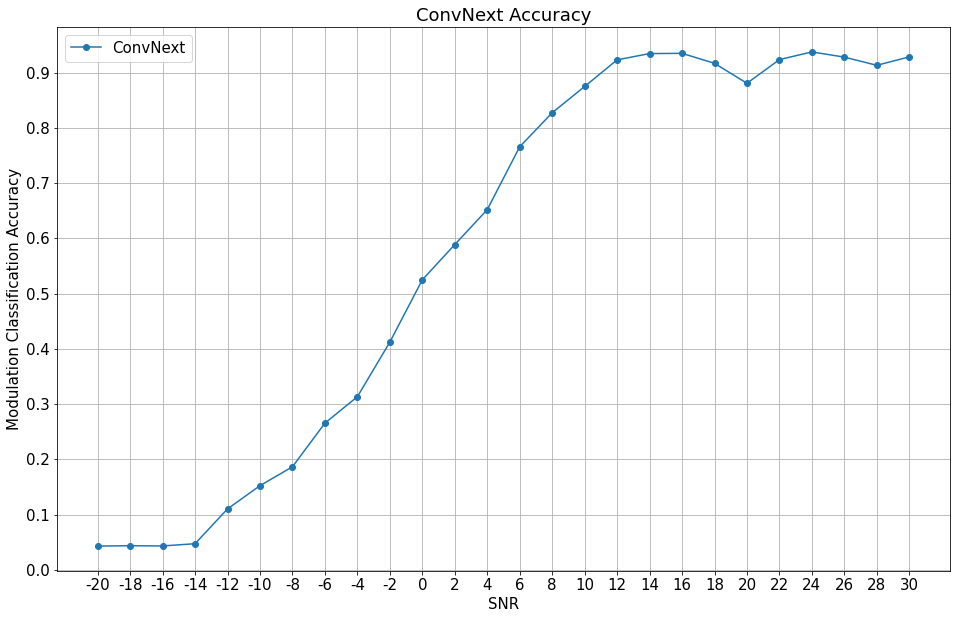

In [21]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.ylabel("Modulation Classification Accuracy")
plt.xlabel("SNR")
plt.plot(acc_convnext.keys(), acc_convnext.values(), '-o', label="ConvNext")
plt.legend()
plt.yticks(np.arange(0, 1, 0.1))
plt.title("ConvNext Accuracy")

## RFNet comparison

In [ ]:
with open("accuracy_convnet.json", "r") as f:
    acc_convnet = json.load(f)

Text(0.5, 1.0, 'ConvNext vs RFNet Accuracy')

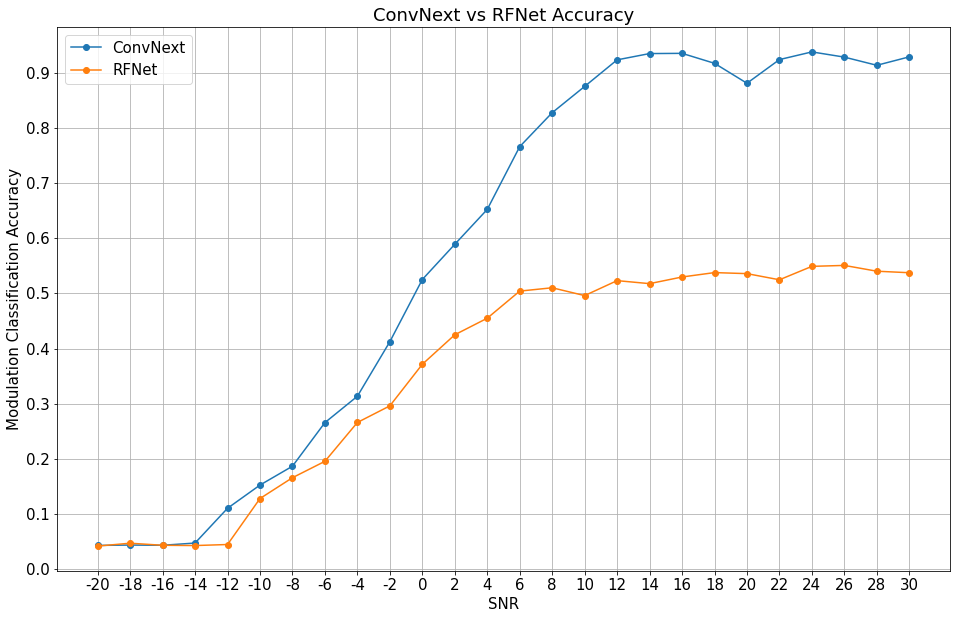

In [22]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.ylabel("Modulation Classification Accuracy")
plt.xlabel("SNR")
plt.plot(acc_convnext.keys(), acc_convnext.values(), '-o', label="ConvNext")
plt.plot(acc_convnet.keys(), acc_convnet.values(), '-o', label="RFNet")
plt.legend()
plt.yticks(np.arange(0, 1, 0.1))
plt.title("ConvNext vs RFNet Accuracy")

## RFNet variations

In [32]:
with open("accuracy_convnet_2_25.json", "r") as f:
    acc_convnet_2_25 = json.load(f)
with open("accuracy_convnetBN.json", "r") as f:
    acc_convnetBN_2_25 = json.load(f)
with open("accuracy_convnetBN_2_50.json", "r") as f:
    acc_convnetBN_2_50 = json.load(f)
with open("accuracy_convnetBN_5_25.json", "r") as f:
    acc_convnetBN_5_25 = json.load(f)

Text(0.5, 1.0, 'ConvNext vs RFNets Accuracies')

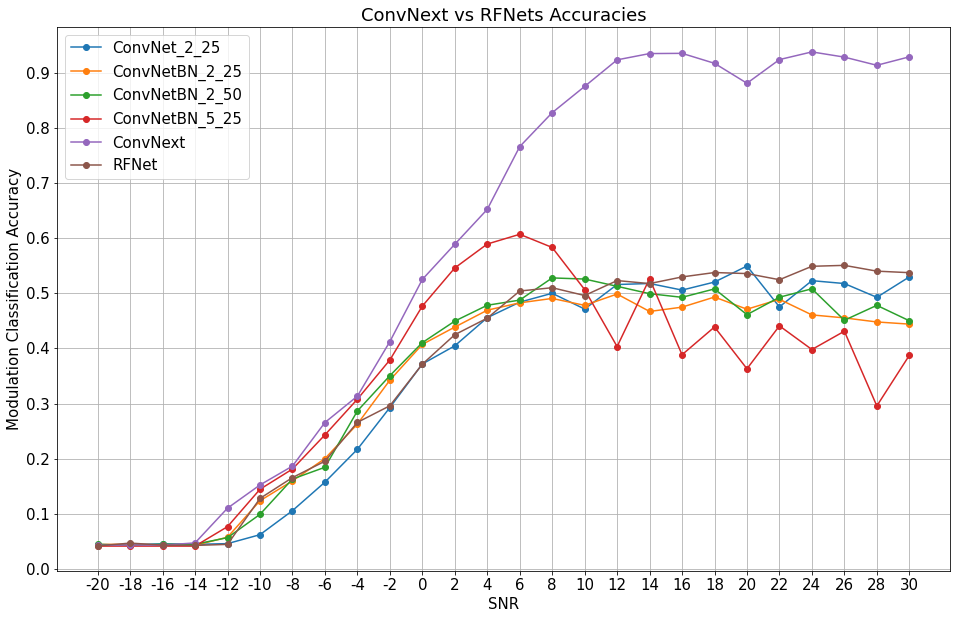

In [33]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.ylabel("Modulation Classification Accuracy")
plt.xlabel("SNR")
plt.plot(acc_convnet_2_25.keys(), acc_convnet_2_25.values(), '-o', label="ConvNet_2_25")
plt.plot(acc_convnetBN_2_25.keys(), acc_convnetBN_2_25.values(), '-o', label="ConvNetBN_2_25")
plt.plot(acc_convnetBN_2_50.keys(), acc_convnetBN_2_50.values(), '-o', label="ConvNetBN_2_50")
plt.plot(acc_convnetBN_5_25.keys(), acc_convnetBN_5_25.values(), '-o', label="ConvNetBN_5_25")
plt.plot(acc_convnext.keys(), acc_convnext.values(), '-o', label="ConvNext")
plt.plot(acc_convnet.keys(), acc_convnet.values(), '-o', label="RFNet")
plt.legend()
plt.yticks(np.arange(0, 1, 0.1))
plt.title("ConvNext vs RFNets Accuracies")